# TF‑IDF + Naive Bayes modelling

In this notebook we build the main text classifier using TF‑IDF features and a Naive Bayes algorithm.  We compare `MultinomialNB` and `ComplementNB` and tune the smoothing parameter `alpha` on a validation split.  The best model and vectorizer are saved to disk.


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import numpy as np

# Load and deduplicate data
file_path = '../data/raw/customer_feedback.csv'
df = pd.read_csv(file_path).drop_duplicates().reset_index(drop=True)
X = df['text']
y = df['category']
# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [5]:
# TF‑IDF vectorizer
vectorizer = TfidfVectorizer(lowercase=True, ngram_range=(1,2), min_df=2)
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)

alphas = [0.1, 0.3, 1.0, 3.0]
best_score = -np.inf
best_params = None
best_model = None

for model_name, Model in [('MultinomialNB', MultinomialNB), ('ComplementNB', ComplementNB)]:
    for alpha in alphas:
        clf = Model(alpha=alpha)
        clf.fit(X_train_vec, y_train)
        y_pred = clf.predict(X_val_vec)
        macro_f1 = f1_score(y_val, y_pred, average='macro')
        acc = accuracy_score(y_val, y_pred)
        print(f"{model_name} alpha={alpha}: accuracy={acc:.3f}, macro_F1={macro_f1:.3f}")
        if macro_f1 > best_score:
            best_score = macro_f1
            best_params = (model_name, alpha)
            best_model = clf
print(f"Best model: {best_params} with macro F1 = {best_score:.3f}")


MultinomialNB alpha=0.1: accuracy=0.826, macro_F1=0.820
MultinomialNB alpha=0.3: accuracy=0.826, macro_F1=0.820
MultinomialNB alpha=1.0: accuracy=0.826, macro_F1=0.820
MultinomialNB alpha=3.0: accuracy=0.826, macro_F1=0.820
ComplementNB alpha=0.1: accuracy=0.826, macro_F1=0.820
ComplementNB alpha=0.3: accuracy=0.826, macro_F1=0.820
ComplementNB alpha=1.0: accuracy=0.826, macro_F1=0.820
ComplementNB alpha=3.0: accuracy=0.826, macro_F1=0.820
Best model: ('MultinomialNB', 0.1) with macro F1 = 0.820


                 precision    recall  f1-score   support

        app_bug       0.75      0.75      0.75         4
billing_problem       1.00      0.60      0.75         5
 delivery_issue       0.83      1.00      0.91         5
          other       1.00      0.75      0.86         4
 refund_request       0.71      1.00      0.83         5

       accuracy                           0.83        23
      macro avg       0.86      0.82      0.82        23
   weighted avg       0.86      0.83      0.82        23



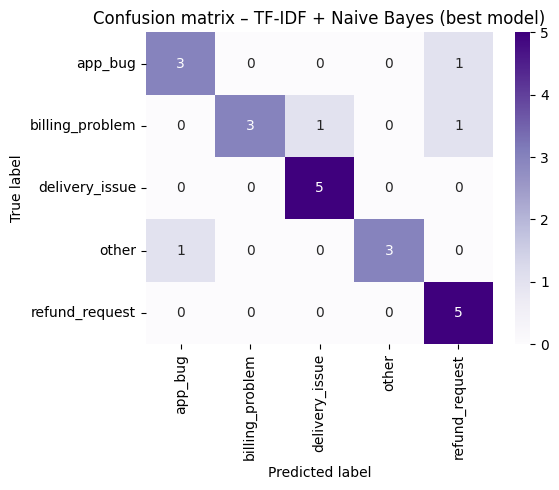

In [6]:
# Save vectorizer and best model
joblib.dump(vectorizer, '../models/vectorizer.joblib')
joblib.dump(best_model, '../models/classifier.joblib')

# Evaluate best model
y_pred = best_model.predict(X_val_vec)
print(classification_report(y_val, y_pred))

# Confusion matrix
labels = best_model.classes_
cm = confusion_matrix(y_val, y_pred, labels=labels)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=labels, yticklabels=labels)
plt.title('Confusion matrix – TF‑IDF + Naive Bayes (best model)')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig('../reports/figures/confusion_matrix_tfidf_nb.png')
plt.show()
# Save classification report separately
with open('../reports/classification_report_tfidf_nb.txt', 'w') as f:
    f.write(classification_report(y_val, y_pred))
